# Demonstration of MCMC non-linear regression with EMCEE and refnx

refnx is a package that can be used for non-linear regression (curvefitting). Here I demonstrate how it can be used to analyse Gaussian curve dataset, with Bayesian MCMC sampling of the posterior distributions of the parameters. This is a very robust way of estimating parameter uncertainties. refnx can also use pymc to do this.

In [1]:
import numpy as np
import emcee
import triangle
from scipy.optimize import leastsq
from refnx.analysis import CurveFitter
import refnx.analysis as ra
from matplotlib.pyplot import *
from lmfit import fit_report
%matplotlib inline
matplotlib.pyplot.rcParams['figure.figsize'] = (10.0, 6.0)
matplotlib.pyplot.rcParams['figure.dpi'] = 600

/Users/anz/Documents/Andy/programming/dev3/lib/python3.4/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


First step is to load some data in.

<Container object of 3 artists>

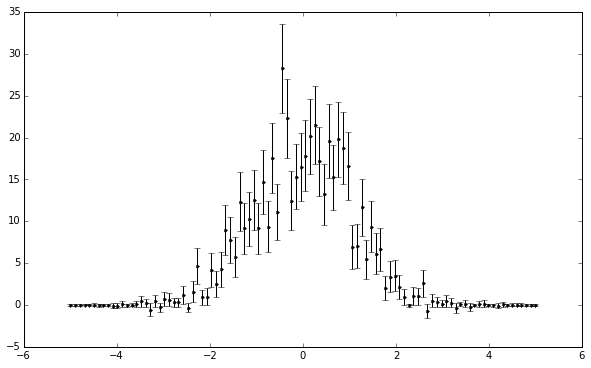

In [2]:
theoretical = np.loadtxt('gauss_data.txt')
xvals, yvals, evals = np.hsplit(theoretical, 3)
xvals = xvals.flatten()
yvals = yvals.flatten()
evals = evals.flatten()
errorbar(xvals, yvals, yerr=evals, fmt='.k')

Define the fit functions. The first type is what you would use for `refnx.analysis.CurveFitter`, the second is a function that you can use with `emcee`.

In [3]:
def gauss(x, p0, *args):
    p = list(p0.valuesdict().values())
    return p[0] + p[1] * np.exp(-((x - p[2]) / p[3])**2)

def gauss2(x, p, *args):
    return p[0] + p[1] * np.exp(-((x - p[2]) / p[3])**2)

Set up initial parameter guesses and lower and upper bounds. The last step is to create an `lmfit.Parameters` instance for use with CurveFitter.

In [4]:
p0 = np.array([0.1, 20., 0.1, 0.1])
bounds_varying = np.array([(-1, 1), (0, 30), (-5., 5.), (0.001, 2)])
params = ra.to_Parameters(p0, bounds=bounds_varying)

The following functions are used with `emcee`. The log-likelihood, the uniform log-prior and the overall log-probability.

In [5]:
def residuals(theta):
    resid = (gauss2(xvals, theta) - yvals) / evals
    return resid
    
def lnlike(theta):
    # log likelihood
    return -0.5 * (np.sum(residuals(theta) ** 2))

def lnprior(theta):
    # uniform prior
    if (np.any(theta > bounds_varying[:, 1])
            or np.any(theta < bounds_varying[:, 0])):
        return -np.inf
    return 0

def lnprob(theta):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta)

Lets fit the data with least squares first.

In [6]:
result = leastsq(residuals, p0, full_output=True)
best_fit = result[0]
best_errors = np.sqrt(np.diag(result[1]))
for mean, std in zip(best_fit, best_errors):
    print("{:<12g} +/-  {:<10g}".format(mean, std))

-0.00245995  +/-  0.0220328 
19.5301      +/-  1.12791   
-0.0828432   +/-  0.0447593 
1.24691      +/-  0.0411562 


Set up the walkers for `emcee`.

In [7]:
ndim, nwalkers = 4, 100
pos = np.array([p0 * (1 + 1e-2 * np.random.randn(ndim))
    for i in range(nwalkers)])

Run the `emcee` sampler

In [8]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)
a = sampler.run_mcmc(pos, 1000)

Discard 100 burn in steps for each walker and flatten the chain.

In [9]:
chain = sampler.chain[:, 100:, :].reshape(-1, 4)

Now we're going to also do the analysis using a `refnx.analysis.CurveFitter` instance. First setup the curvefitter.

In [10]:
f = CurveFitter(gauss, xvals, yvals, params, edata=evals)

Now do the sampling with CurveFitter instead. There are 100 walkers, we do 2000 steps on each walker. After the sampling discard the first 100 steps of each walker and take every 5th step

In [11]:
chains = f.emcee(nwalkers=100, steps=2000, burn=100, thin=5)
chains = chains.reshape(-1, 4)

The following plot shows the posterior distributions for each parameter

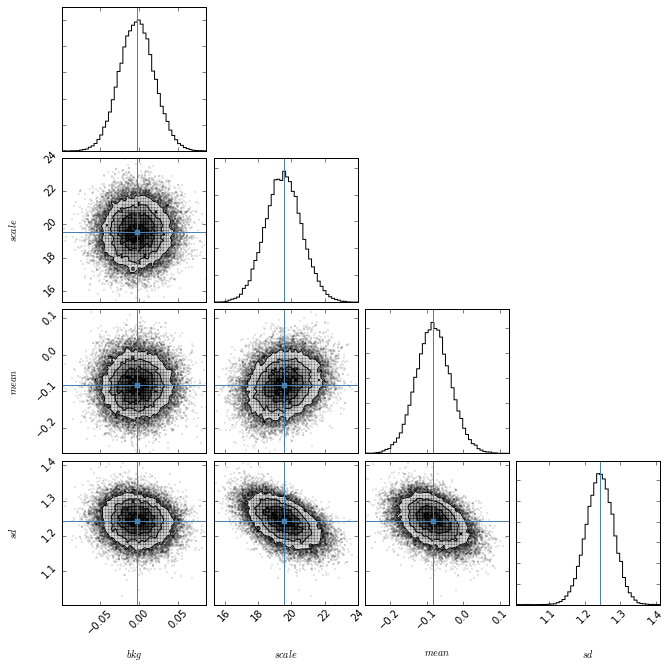

In [12]:
b=triangle.corner(chains, labels=["$bkg$", "$scale$", "$mean$", "$sd$"], truths=ra.values(f.params))

But what about the fits, are they good?

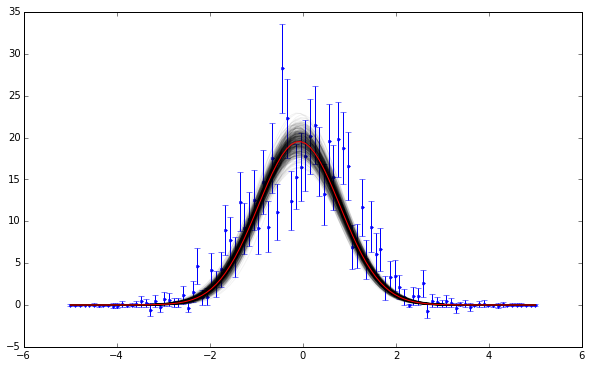

In [13]:
errorbar(xvals, yvals, yerr=evals, fmt=".")
for pars in chains[np.random.randint(len(chains), size=500)]:
    plot(xvals, gauss2(xvals, pars), color="k", alpha=0.05)
plot(xvals, gauss(xvals, f.params), color='r')

The following fit parameters are obtained. Lets compare them to the least squares output.

In [14]:
print("emcee")
print("-----")

print(fit_report(f.params))

print("\nleastsq")
print("-------")

for mean, std in zip(best_fit, best_errors):
    print("{:<12g} +/-  {:<10g}".format(mean, std))

emcee
-----
[[Variables]]
    p0:  -0.00261755 +/- 0.022482 (858.91%) (init= 0.1)
    p1:   19.5324508 +/- 1.106139 (5.66%) (init= 20)
    p2:  -0.08228678 +/- 0.047832 (58.13%) (init= 0.1)
    p3:   1.24235055 +/- 0.039381 (3.17%) (init= 0.1)
[[Correlations]] (unreported correlations are <  0.100)
    C(p1, p3)                    = -0.517 
    C(p2, p3)                    = -0.393 
    C(p1, p2)                    =  0.207 
    C(p0, p3)                    = -0.119 

leastsq
-------
-0.00245995  +/-  0.0220328 
19.5301      +/-  1.12791   
-0.0828432   +/-  0.0447593 
1.24691      +/-  0.0411562 
